3. Implement parallel version of spectrogram (2 points)

4. Plot speedup vs. number of processes/threads (2 points)

In [8]:
%%writefile specgram_par.py
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt

nwindowsteps=1000
freq_limit=10

t = np.linspace(-20*2*np.pi, 20*2*np.pi, 2**14)
y = np.sin(t) * np.exp(-t**2/2/20**2)
y = y + np.sin(3*t) * np.exp(-(t-5*2*np.pi)**2/2/20**2)
y = y + np.sin(5.5*t) * np.exp(-(t-10*2*np.pi)**2/2/5**2)
y = y + np.sin(4*t) * np.exp(-(t-7*2*np.pi)**2/2/20**2)

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Distribute time and signal to each process
t_local = np.array_split(t, size)[rank]
y_local = np.array_split(y, size)[rank]

# Calculate local parameters
window_width = (t_local[-1] - t_local[0]) / nwindowsteps
window_positions = np.linspace(t_local[0], t_local[-1], nwindowsteps)
w_spec_local = np.fft.fftfreq(len(y_local), d=(t[1] - t[0]) / 2 / np.pi)

freq_limit_idx = np.where(w_spec_local >= freq_limit)[0][0] if freq_limit else -1
w_spec_local = w_spec_local[:freq_limit_idx]

# Calculate local spectrogram
specgram_local = np.array([]).reshape(0, freq_limit_idx)
for w_pos in window_positions:
    window_function = np.exp(-(t_local - w_pos) ** 2 / 2 / window_width ** 2)
    y_window = y_local * window_function
    sp = np.fft.fft(y_window)
    sp = np.abs(sp) ** 2
    sp = sp[:freq_limit_idx]
    specgram_local = np.vstack([specgram_local, sp])

# Gather spectrogram data from all processes
specgram = comm.gather(specgram_local, root=0)

if rank == 0:
    # Concatenate the spectrogram from all processes
    specgram = np.concatenate(specgram, axis=0).T
    np.save('result.npy', specgram)

MPI.Finalize()

Writing specgram_par.py


In [10]:
from time import time

times = []
start = time()
!mpirun -n 1 --allow-run-as-root --oversubscribe python specgram_par.py
end = time() - start
times.append(end)

In [11]:
start = time()
!mpirun -n 2 --allow-run-as-root --oversubscribe python specgram_par.py
end = time() - start
times.append(end)

In [12]:
start = time()
!mpirun -n 3 --allow-run-as-root --oversubscribe python specgram_par.py
end = time() - start
times.append(end)

In [13]:
start = time()
!mpirun -n 4 --allow-run-as-root --oversubscribe python specgram_par.py
end = time() - start
times.append(end)

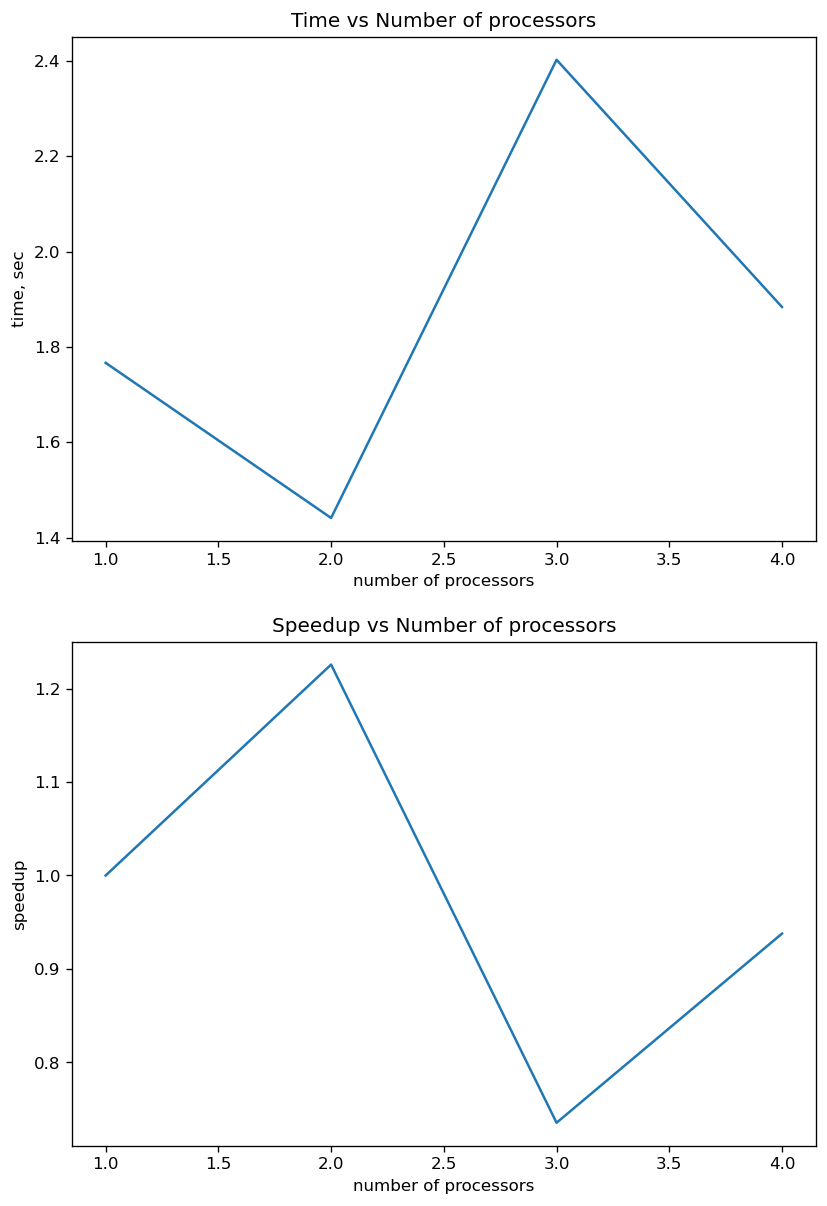

In [15]:
import matplotlib.pyplot as plt

num_procs = range(1, 5)
plt.figure(figsize=(8,12), dpi=120)
plt.subplot(211)
plt.plot(num_procs, times)
plt.title('Time vs Number of processors')
plt.xlabel('number of processors')
plt.ylabel('time, sec')
plt.subplot(212)
plt.plot(num_procs, [times[0]/x for x in times])
plt.title('Speedup vs Number of processors')
plt.xlabel('number of processors')
plt.ylabel('speedup')
plt.show()